In [1]:
import matplotlib.pyplot as plt
import numpy as np
import trimesh
import os

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/modelnet40-princeton-3d-object-dataset")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/modelnet40-princeton-3d-object-dataset/versions/1


In [27]:
# Path to the downloaded dataset
dataset_path = path  # The path you got from kagglehub

# Example category (e.g., 'airplane') and sample file name
category = 'airplane'  # Replace with any other category
sample_file = 'airplane_0435.off'  # Replace with the actual file name

# Construct the full path to the .off file
sample_file_path = os.path.join(dataset_path, 'ModelNet40', category, 'train', sample_file)

# Load the mesh using trimesh
mesh = trimesh.load_mesh(sample_file_path)

# Visualize the mesh
mesh.show()


Output hidden; open in https://colab.research.google.com to view.

In [4]:
import os

# Check the contents of the directory where the point clouds should be
category = 'airplane'  # Replace with your category
category_dir = os.path.join(dataset_path, 'ModelNet40', category, 'train')
files_in_directory = os.listdir(category_dir)

print("Files in directory:", files_in_directory)


Files in directory: ['airplane_0236.off', 'airplane_0303.off', 'airplane_0140.off', 'airplane_0435.off', 'airplane_0468.off', 'airplane_0297.off', 'airplane_0338.off', 'airplane_0549.off', 'airplane_0077.off', 'airplane_0105.off', 'airplane_0277.off', 'airplane_0425.off', 'airplane_0180.off', 'airplane_0446.off', 'airplane_0466.off', 'airplane_0368.off', 'airplane_0197.off', 'airplane_0073.off', 'airplane_0301.off', 'airplane_0144.off', 'airplane_0125.off', 'airplane_0283.off', 'airplane_0562.off', 'airplane_0464.off', 'airplane_0328.off', 'airplane_0493.off', 'airplane_0624.off', 'airplane_0230.off', 'airplane_0235.off', 'airplane_0533.off', 'airplane_0534.off', 'airplane_0189.off', 'airplane_0560.off', 'airplane_0376.off', 'airplane_0349.off', 'airplane_0454.off', 'airplane_0124.off', 'airplane_0053.off', 'airplane_0238.off', 'airplane_0574.off', 'airplane_0382.off', 'airplane_0158.off', 'airplane_0390.off', 'airplane_0167.off', 'airplane_0402.off', 'airplane_0506.off', 'airplane_018

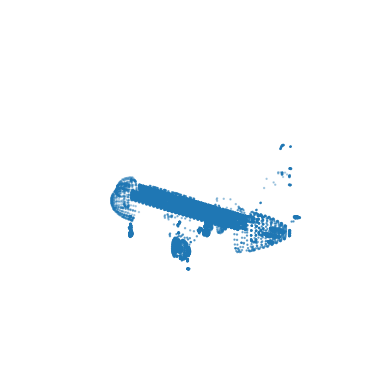

In [11]:
# Convert point cloud data to numpy array for visualization
point_cloud_data = np.array(mesh.vertices)

# Plotting 3D points using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the points
ax.scatter(point_cloud_data[:, 0], point_cloud_data[:, 1], point_cloud_data[:, 2], s=0.5)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_axis_off()

# Show the plot
plt.show()

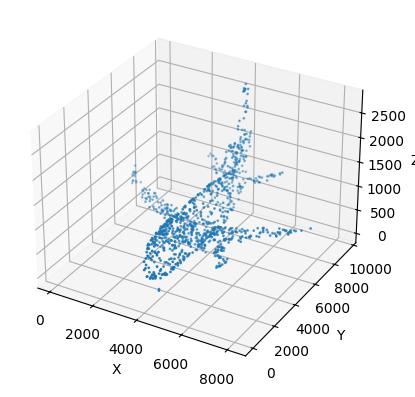

In [20]:
# Path to the downloaded dataset
dataset_path = path  # The path you got from kagglehub

# Example category and sample file name
category = 'airplane'  # Replace with the desired category
sample_file = 'airplane_0236.off'  # Replace with the actual .off file

# Construct the full path to the .off file
sample_file_path = os.path.join(dataset_path, 'ModelNet40', category, 'train', sample_file)

# Load the mesh using trimesh
mesh = trimesh.load_mesh(sample_file_path)

# Sample points from the mesh surface (e.g., 1000 points)
num_points_to_sample = 1000
sampled_points = mesh.sample(num_points_to_sample)

# Plot the sampled points in 3D using Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], s=1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [21]:
# install Python OT
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 10.0 MB/s eta 0:00:00


In [22]:
import numpy as np
import cv2
import scipy as sp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import time

import ot

In [48]:
def get_lambdas(matrix_temp_list, measure_temp_list, matrix_input, mesaure_input):
  '''
  get_lambdas computes the barycentric weights (lambda_1,...,lamnda_S), where S is the number of templates,
  from the simplifyed GW-Barycenter Analysis Problem by using the Lagrange Multipliers approach
  and recontruct a matrix that is "close" to a barycentric matrix
  Input:
    matrix_temp_list: list of the template matrices, that is, a list of S arrays of different dimensions (Ns,Ns),
            each one represents an (Ns x Ns) matrix that is one of the S different dissimilarity matrices of the S templates
    measure_temp_list: list of S arrays of fifferent dimensions Ns,
            each one represents a probability vector in R^Ns that is one of the S probability measures of the S templates
    matrix_input: matrix representing a dissimilarity matrix you want to analyze: (M,M) array
    measure_input: probability vector of length M (array)
  Output:
  lambdas = vector of weights, as many as number of templates: S array
            it is not guaranteed lambdas[s] >=0
  matrix_output = new synthesize matrix

  '''
  S = len(matrix_temp_list)

  pi_list = []
  F_list = []

  Q = (mesaure_input.reshape(-1,1) @ mesaure_input.reshape(1,-1))
  Q = 1. / Q

  for s in range(S):
      pi_s = ot.gromov.gromov_wasserstein(matrix_temp_list[s], matrix_input, measure_temp_list[s], mesaure_input)
      pi_list.append(pi_s)
      F_s = Q * (pi_s.T @ matrix_temp_list[s] @ pi_s)
      F_list.append(F_s)

  K = np.zeros((S,S))
  b = np.zeros(S)
  for i in range(S):
      b[i] = np.trace(matrix_input @ F_list[i])
      for j in range(S):
          K[i,j] = np.trace(F_list[i] @ F_list[j])

  K_aug = np.hstack([K, -0.5 * np.ones(S).reshape(-1,1)])
  last_row = np.ones(K_aug.shape[1]).reshape(1,-1)
  last_row[0,-1] = 0
  K_aug = np.vstack([K_aug,last_row])

  b_aug = np.hstack([b, [1]])

  lambdas = np.linalg.solve(K_aug, b_aug)

  lambdas = lambdas[0:-1]

  matrix_output = np.zeros_like(matrix_input)

  for s in range(S):
    matrix_output += lambdas[s] * F_list[s]
    matrix_input = matrix_output

  return matrix_output, lambdas

Get templates

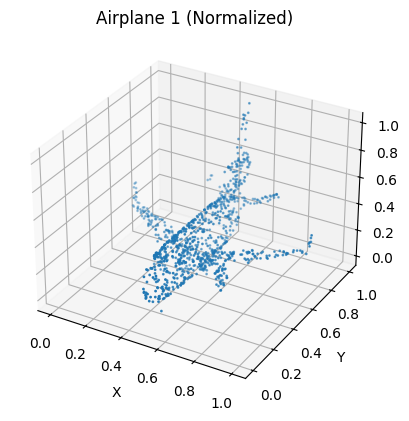

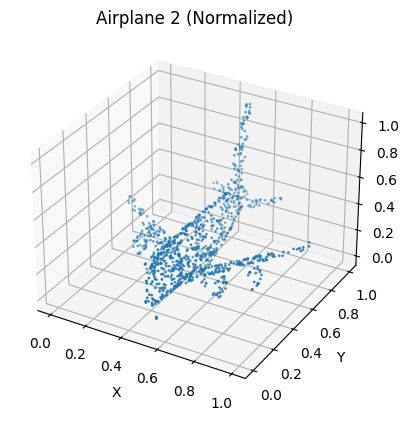

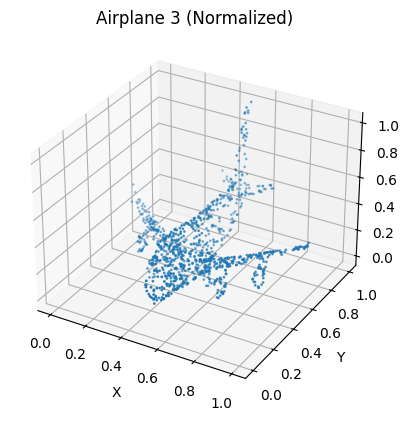

In [73]:
# Path to the downloaded dataset
dataset_path = path  # The path you got from kagglehub

#number of templates
n_temp = 3

# List of 5 different airplane sample files
airplane_files = [
    'airplane_0236.off',
    'airplane_0435.off',
    'airplane_0215.off',
    #'airplane_0162.off',
    #'airplane_0303.off',
]  # Replace with the actual files in your dataset

# Number of points to sample from each airplane
num_points_to_sample = 1000

# Store the sampled points for each airplane
sampled_airplanes = []
# list of dissimilarity matrices
matrix_temp_list = []
# list of measures
measure_temp_list = []

# Loop through each airplane file and sample points
for airplane_file in airplane_files:
    # Construct the full path to the .off file
    sample_file_path = os.path.join(dataset_path, 'ModelNet40', 'airplane', 'train', airplane_file)

    # Load the mesh using trimesh
    mesh = trimesh.load_mesh(sample_file_path)

    # Sample points from the mesh surface
    sampled_points = mesh.sample(num_points_to_sample)

    # Normalize the points to fit within [0, 1]^3
    min_vals = sampled_points.min(axis=0)
    max_vals = sampled_points.max(axis=0)
    normalized_points = (sampled_points - min_vals) / (max_vals - min_vals)

    # Append the normalized points to the list
    sampled_airplanes.append(normalized_points)

    # Dissimilarity matrices
    dist_matrix = sp.spatial.distance.cdist(normalized_points, normalized_points)
    matrix_temp_list.append(dist_matrix)

    # Measure
    p_s = np.ones(num_points_to_sample) / num_points_to_sample
    measure_temp_list.append(p_s)

# Plot each normalized airplane's points in a separate 3D plot
for i, sampled_points in enumerate(sampled_airplanes):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the sampled points for the current airplane
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], s=1)

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Airplane {i+1} (Normalized)")

    # Show the plot
    plt.show()




Get vector of weights

In [74]:
lambdas_list = np.random.rand(n_temp)
lambdas_list = lambdas_list/lambdas_list.sum()

Synthesize a Barycenter using POT

In [75]:
M = 1000 # Dimension of output barycentric matrix is MxM.

b = np.ones(M) / M   # Uniform target probability vector
# b = np.random.rand(M)
# b = b/b.sum()   # Random target probability vector

B =  ot.gromov.gromov_barycenters(M, matrix_temp_list, measure_temp_list, b, lambdas_list)  # Synthesize barycenter matrix

Recover the vector of weights 'lambdas' by only knowing the Barycenter

In [76]:
B_recon, lambdas = get_lambdas(matrix_temp_list, measure_temp_list, B, b)
print('Lambdas Error = ', np.linalg.norm(lambdas_list - lambdas, 1))
print('lambdas = ', lambdas)

Lambdas Error =  1.527250548249981e-14
lambdas =  [0.03361609 0.66483169 0.30155222]


In [81]:
B = (B + B.T) / 2
B_recon = (B_recon + B_recon.T) / 2

In [87]:
print(np.min(B), np.min(B_recon))  # Ensure no negative values

0.0 0.0


In [90]:
## Compare Original target vs reconstruction
gromov_distance = ot.gromov.gromov_wasserstein(B,B_recon,b,b, log=True, tol=1e-9)[1]
gw_dist = gromov_distance['gw_dist']
print(f'GW(Target,Reconstructed Target): {gw_dist}')

GW(Target,Reconstructed Target): -1.457167719820518e-16


Visualization

In [83]:
# Create an MDS instance
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)

In [84]:
## Fit and transform the distance matrix
points_B = mds.fit_transform(B)
points_B_recon = mds.fit_transform(B_recon)

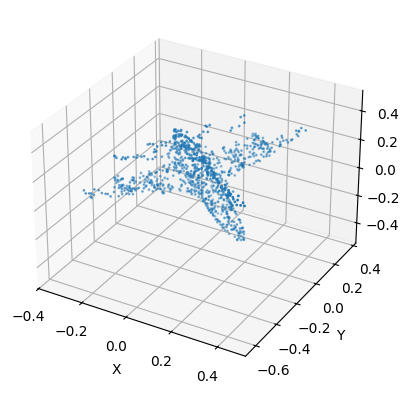

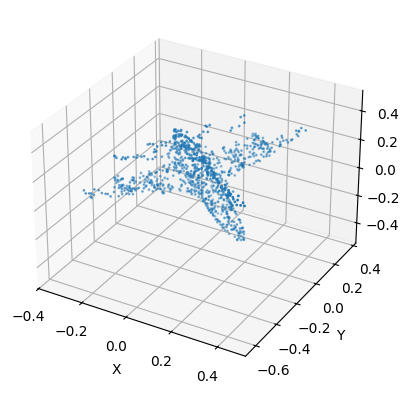

In [85]:
# Plot the sampled points in 3D using Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_B[:, 0], points_B[:, 1], points_B[:, 2], s=1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

# Plot the sampled points in 3D using Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_B_recon[:, 0], points_B_recon[:, 1], points_B_recon[:, 2], s=1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()